In [1]:
import haiku as hk
import jax
import jax.random as jrnd
import jax.numpy as jnp

import numpy as np
import optax

In [2]:
from phasor_jax.modules import *
from phasor_jax.utils import *
from phasor_jax.training import *

In [3]:
import matplotlib.pyplot as plt

# Dataset

In [4]:
#choose standard dataset here - e.g. MNIST, Fashion MNIST, Kuzushiji MNIST
dataset = "fashion_mnist"

In [5]:
#load the dataset
n_batch = 128
train_ds, x_train, y_train = load_dataset(dataset, split="train", is_training=True, batch_size=n_batch)
train = iter(train_ds)

Metal device set to: Apple M1 Max

systemMemory: 64.00 GB
maxCacheSize: 24.00 GB



2023-05-16 16:49:04.944728: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [6]:
n_train = x_train.shape[0]
x_train.shape

(60000, 28, 28, 1)

# Model

In [7]:
def in_layer(x, 
           vsa_dimension: int = 1024,
           spiking: bool = False,
           **kwargs):
    
    x = scale_mnist(x)
    #project into VSA
    x = ProjectAll(vsa_dimension)(x)
    x = layer_norm(x)

    return x

In [8]:
def mlp(x, 
           n_layers: int = 1,
           n_hidden: int = 128,
           vsa_dimension: int = 1024,
           spiking: bool = False,
           repeats: int = 3,
           is_training: bool = False,
           **kwargs):
    """
    Simple MLP model with scalable number of hidden layers
    """
    
    x = scale_mnist(x)
    #project into VSA
    x = ProjectAll(vsa_dimension)(x)
    x = layer_norm(x)

    if spiking:
        x = phase_to_train(x, repeats=repeats)
    
    outputs = []
    for i in range(n_layers):
        x = conv_1d(n_hidden)(x, spiking=spiking, **kwargs)
        outputs.append(x)

    x = conv_1d(10)(x,  spiking=spiking, **kwargs)
    outputs.append(x)

    #only return the single output if training
    if is_training:
        return x

    if spiking: 
        p = train_to_phase(x)
        
        return p, outputs
    else:

        return x, outputs

In [9]:
#declare the model as a transformation
model = hk.transform(mlp)

In [10]:
#instantiate the first PRNG key
key = jrnd.PRNGKey(42)

In [11]:
#split the key and use it to create the model's initial parameters
key, subkey = jrnd.split(key)
params = model.init(subkey, x_train[0:10,...])

/Users/wilkie/anaconda3/envs/jax/lib/python3.10/site-packages/haiku/_src/base.py:515: UserWarning: Explicitly requested dtype float requested in ones is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  param = init(shape, dtype)


In [12]:
#create an instance of the RMSprop optimizer
opt = optax.rmsprop(0.001)

In [13]:
#get a sample batch from the train set
b = next(train)
x = b['image']
y = b['label']

b x y c ->  (128, 28, 28, 1)


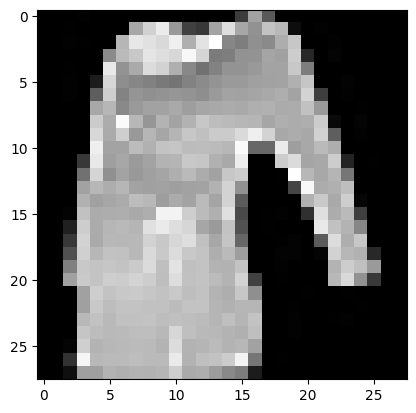

In [14]:
print("b x y c -> ", x.shape)
plt.imshow(x[0,...], cmap="gray");

Text(0, 0.5, 'Density')

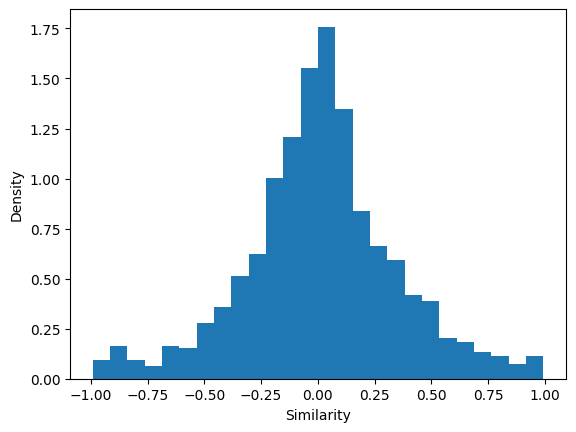

In [15]:
#sample the initial similarities the model produces between an 
# image and the class codebook. 

pred = model.apply(params, key, x)[0]

plt.hist(np.array(pred.ravel()), bins=26, density=True)
plt.xlabel("Similarity")
plt.ylabel("Density")

Text(0.5, 1.0, 'Pre-Train Similarity')

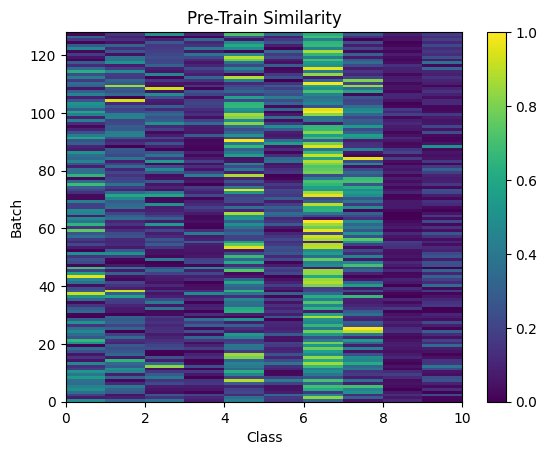

In [16]:
#Visualize the similarity each sample produces to the class codebook
plt.pcolor(jnp.abs(pred), vmax=1.0, vmin=0.0)
plt.xlabel("Class")
plt.ylabel("Batch")
plt.colorbar()
plt.title("Pre-Train Similarity")

In [17]:
loss_fn = lambda yh, y: quadrature_loss(yh, y, num_classes=10)

In [18]:
# Compute a sample of the loss function over these similarities. 
# Takes the complement of the similarity for the correct class label.
# This value (distance) will be minimized over training.

jnp.mean(loss_fn(pred, y))

DeviceArray(0.4549652, dtype=float32)

# Training

In [19]:
params_t, losses = train_model(model, 
                               key, 
                               params = params, 
                               dataset = train, 
                               optimizer = opt, 
                               loss_fn = loss_fn, 
                               batches = 500)

100%|██████████| 500/500 [00:17<00:00, 28.03it/s]


Text(0, 0.5, 'Loss')

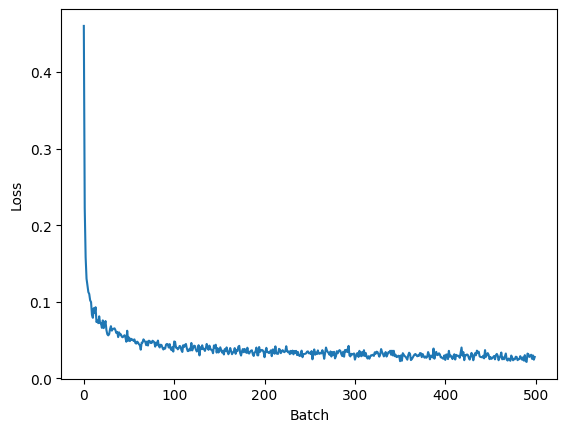

In [20]:
#Plot the history of the loss values over batches
plt.plot(losses)
plt.xlabel("Batch")
plt.ylabel("Loss")

# Test

In [21]:
#Load the testing dataset
test_ds, x_test, y_test = load_dataset(dataset, split="test", is_training=False, repeat = False, batch_size=n_batch)
test = iter(test_ds)

In [22]:
#Load a non-repeating copy of the training dataset
train2 = iter(load_dataset(dataset, split="train", is_training=False, repeat = False, batch_size=n_batch)[0])

In [23]:
#define a labmda to compute accuracy we can dispatch over batches
eval_fn = lambda x: model.apply(params_t, key, x)
eval_fn_spk = lambda x: model.apply(params_t, key, x, spiking=True)

In [24]:
predictions = [eval_fn(b['image']) for b in iter(test_ds)]

In [25]:
yh = eval_fn(x)

In [26]:
phases = predictions[0]

In [27]:
phases[0].shape

(128, 10)

In [28]:
from phasor_jax.spiking import *

In [29]:
accuracy_quadrature(yh[0], y).shape

(128,)

In [30]:
usage = jnp.stack([np.array(list(map(matrix_usage, r[1]))) for r in predictions])

In [31]:
np.mean(usage, axis=0)

DeviceArray([1., 1.], dtype=float32)

In [32]:
#compute the test set accuracy
preds = jnp.concatenate([r[0] for r in predictions])
test_acc = jnp.mean(accuracy_quadrature(preds, y_test))
print("Test set accuracy is ", test_acc)

Test set accuracy is  0.8447


In [34]:
eval_fn_spk = lambda x: model.apply(params_t, key, x, spiking=True)
phase = eval_fn_spk(x)

AssertionError: GPU Current function uses multi-dimensional index spike train

In [ ]:
phase[1]

[SpikeTrain(indices=[array([    0,     0,     0, ..., 16383, 16383, 16383])], times=array([1.07, 2.11, 3.15, ..., 7.78, 8.77, 9.77]), full_shape=(128, 128), offset=0.25),
 SpikeTrain(indices=[array([   0,    0,    0, ..., 1279, 1279, 1279])], times=array([1.02, 2.02, 3.03, ..., 7.  , 8.  , 9.  ]), full_shape=(128, 10), offset=0.5)]

In [36]:
st = phase[1][0]

In [37]:
len(st.times)

161328

In [38]:
trains = phase[1]

In [99]:
step = 0.002

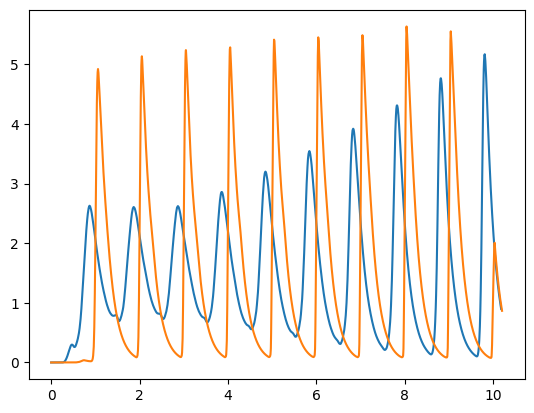

In [100]:
field0 = calculate_field(trains[0], decay = -5, impulse = 1/128, t_step = step)
field1 = calculate_field(trains[1], decay = -5, impulse = 1/10, t_step = step)
plt.plot(field0.t, field0.y.transpose())
plt.plot(field1.t, field1.y.transpose())

In [76]:
t0 = find_spikes(field0, trains[0].offset, complex=False, threshold=1)

In [77]:
t1 = find_spikes(field1, trains[1].offset, complex=False, threshold=1)

In [78]:
arr = inhibit_cross(trains[1], t1, 0.05)

In [79]:
len(trains[1].times)

11932

In [80]:
len(arr.times)

10318

In [81]:
t0.times

array([0.87 , 1.868, 2.868, 3.85 , 3.862, 4.85 , 5.842, 6.832, 7.82 ,
       7.83 , 8.812, 8.818, 9.808])

In [82]:
t1.times

array([ 1.06 ,  2.052,  3.05 ,  4.05 ,  5.044,  6.044,  7.044,  8.04 ,
        9.04 , 10.032])

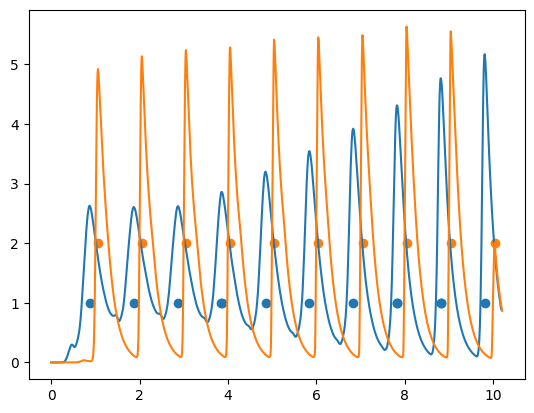

In [83]:
plt.plot(field0.t, field0.y.transpose())
plt.plot(field1.t, field1.y.transpose())
plt.scatter(t0.times, np.ones_like(t0.times))
plt.scatter(t1.times, 2*np.ones_like(t1.times))

In [84]:
np.diff(field0.y, axis=1)

array([[ 0.        ,  0.        ,  0.        , ..., -0.00919876,
        -0.00910723, -0.00901662]])

In [108]:
field0.y.shape

(1, 5091)

In [109]:
from scipy.ndimage import gaussian_filter1d

In [111]:
def smooth_diff(field: ODESolution, sigma: float = 1.0, t_step: float = 0.01):
    v = field.y
    dv = np.diff(v, axis=1) / t_step
    dv = gaussian_filter1d(dv, sigma)
    t = field.t[0:-1] + t_step / 2.0
    soln = ODESolution()
    soln.y = dv
    soln.t = t
    return soln


In [121]:
df0 = smooth_diff(field0, sigma=5)

In [122]:
dt0 = find_spikes(df0, trains[0].offset, complex=False, threshold=1)

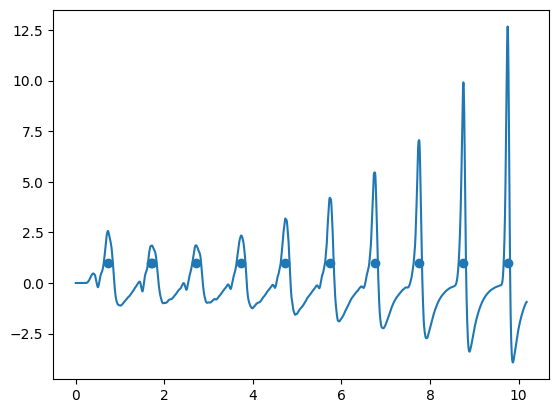

In [123]:
plt.plot(df0.t, df0.y.transpose())
#plt.plot(df1.t, df1.y.transpose())
plt.scatter(dt0.times, np.ones_like(dt0.times))
#plt.scatter(dt1.times, 2*np.ones_like(dt1.times))

In [124]:
df1 = smooth_diff(field1)

In [125]:
dt1 = find_spikes(df1, trains[1].offset, complex=False, threshold=1)

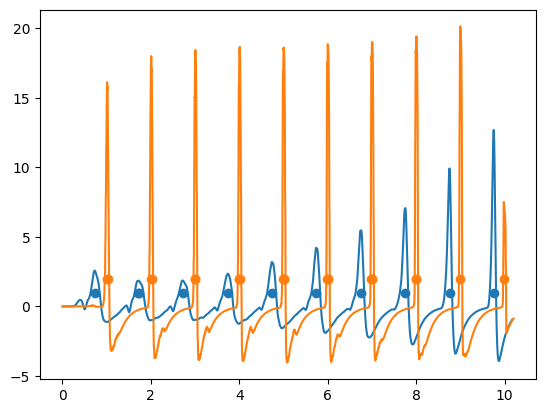

In [126]:
plt.plot(df0.t, df0.y.transpose())
plt.plot(df1.t, df1.y.transpose())
plt.scatter(dt0.times, np.ones_like(dt0.times))
plt.scatter(dt1.times, 2*np.ones_like(dt1.times))

In [127]:
dt0.times

array([0.733, 1.703, 1.725, 2.717, 3.741, 4.737, 5.739, 6.755, 7.755,
       8.755, 9.755])

In [128]:
dt1.times

array([1.013, 1.021, 2.009, 2.019, 2.991, 3.009, 3.991, 4.003, 4.011,
       4.989, 5.003, 5.011, 5.989, 6.003, 6.009, 6.989, 7.003, 7.011,
       7.991, 8.007, 8.999, 9.983])

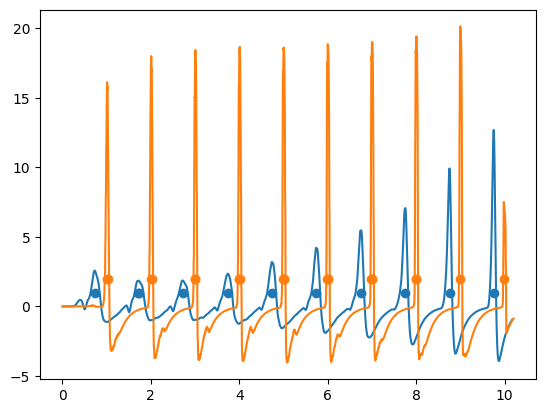

In [129]:
plt.plot(df0.t, df0.y.transpose())
plt.plot(df1.t, df1.y.transpose())
plt.scatter(dt0.times, np.ones_like(dt0.times))
plt.scatter(dt1.times, 2*np.ones_like(dt1.times))

In [117]:
res = p.load(open("phasor_1_layers_angle_0.0.p", "rb"))

In [121]:
res['accuracy_spiking'].shape

(10000,)

In [122]:
np.mean(res['accuracy_spiking'])

DeviceArray(0.66005456, dtype=float32)

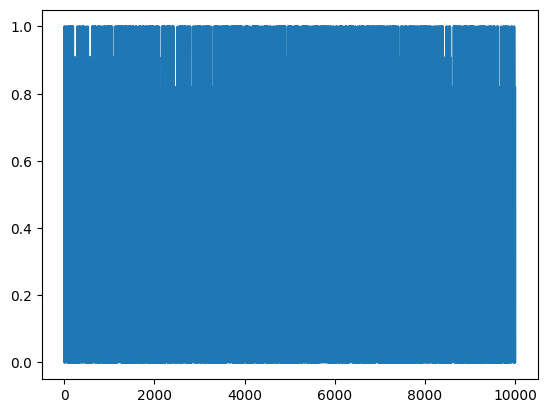

In [120]:
plt.plot(res['accuracy_spiking'])

In [100]:
test_acc_spk = np.mean(accuracy_quadrature(train_to_phase(phase[1][-1]), y), axis=1)

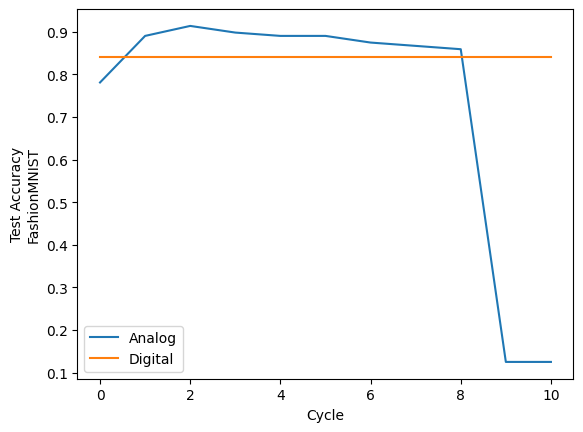

In [101]:
plt.plot(test_acc_spk, label="Analog")
plt.plot(test_acc * np.ones_like(test_acc_spk), label="Digital")
plt.xlabel("Cycle")
plt.ylabel("Test Accuracy\nFashionMNIST")
plt.legend()

In [ ]:
eval_fn_spk = lambda x: model.apply(params_t, key, x, spiking=True,)
phase = eval_fn_spk(x)

In [64]:
phase.shape

(128, 10, 11)

In [74]:
phase_spk = [eval_fn_spk(b['image']) for b in tqdm(iter(test_ds))]

79it [04:21,  3.30s/it]


In [76]:
phase_spk2 = jnp.concatenate(phase_spk, axis=0)

In [77]:
phase_spk2.shape

(10000, 10, 11)

In [81]:
full_test_acc = np.mean(accuracy_quadrature(phase_spk2, y_test), axis=1)

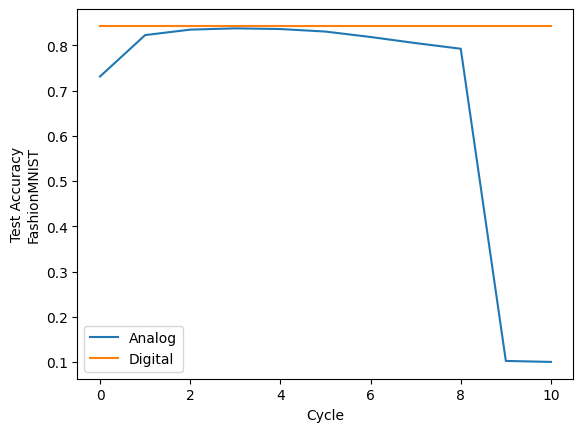

In [83]:
plt.plot(full_test_acc, label="Analog")
plt.plot(test_acc * np.ones_like(test_acc_spk), label="Digital")
plt.xlabel("Cycle")
plt.ylabel("Test Accuracy\nFashionMNIST")
plt.legend()

In [106]:
eval_fn_spk_masked = lambda x, ma: model.apply(params_t, key, x, spiking=True, mask_angle = ma) 

In [110]:
np.mean(accuracy_quadrature(eval_fn_spk_masked(x, 1.0), y), axis=1)

DeviceArray([0.1171875], dtype=float32)

In [109]:
np.mean(accuracy_quadrature(eval_fn_spk_masked(x, 0.00), y), axis=1)

DeviceArray([0.796875 , 0.890625 , 0.9140625, 0.90625  , 0.890625 ,
             0.875    , 0.8671875, 0.8515625, 0.828125 , 0.1171875,
             0.1171875], dtype=float32)

In [111]:
def test_mask_angle(mask_angle: float):
    phases = jnp.concatenate([eval_fn_spk_masked(b['image'], mask_angle) for b in tqdm(iter(test_ds))], axis=0)
    accuracy =  np.mean(accuracy_quadrature(phases, y_test), axis=1)
    return accuracy

In [112]:
angles = np.linspace(0.0, 0.10, 11)

In [ ]:
test_mask_angle(0.10)

In [113]:
masked_accuracies = list(map(test_mask_angle, angles))

79it [04:18,  3.27s/it]
79it [04:20,  3.30s/it]
79it [04:31,  3.44s/it]
79it [04:07,  3.13s/it]
79it [04:07,  3.13s/it]
79it [04:07,  3.13s/it]
79it [04:06,  3.13s/it]
79it [04:01,  3.05s/it]
79it [04:00,  3.05s/it]
79it [04:03,  3.09s/it]
79it [04:03,  3.08s/it]


In [114]:
ama = jnp.stack(masked_accuracies)

In [115]:
ama.shape

(11, 11)

In [116]:
ama.shape

(11, 11)

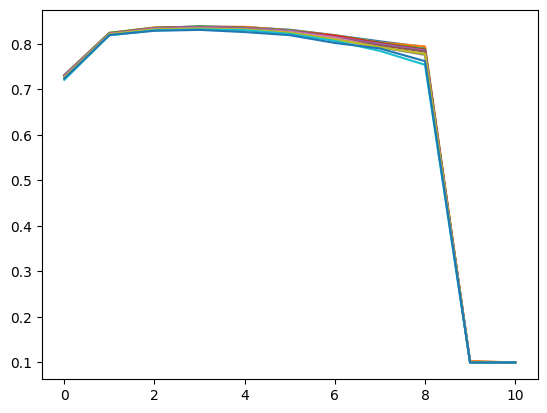

In [117]:
plt.plot(ama.transpose());